In [1]:
import numpy
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class CNN_1(torch.nn.Module):
  def __init__(self, output_classes, pool_type, pool_size):
    super().__init__()
    self.sequential = torch.nn.Sequential(
        torch.nn.Conv2d(3,6,3),
        torch.nn.Conv2d(6,12,3),
        pool_type(pool_size,pool_size),
        torch.nn.Conv2d(12,24,3),
        torch.nn.Conv2d(24,48,3),
        pool_type(pool_size,pool_size))
    self.classify = torch.nn.Sequential(
        torch.nn.Linear(48 * 5 * 5, 600),
        torch.nn.Linear(600, 300),
        torch.nn.Linear(300, output_classes),
        torch.nn.Softmax())
    
  def forward(self, x):
    output = self.sequential(x)
    output = output.view(-1,48*5*5)
    output = self.classify(output)
    return output

class CNN_2(torch.nn.Module):
  def __init__(self, output_classes, pool_type, pool_size):
    super().__init__()
    self.sequential = torch.nn.Sequential(
        torch.nn.Conv2d(3,6,3),
        pool_type(pool_size,pool_size),
        torch.nn.BatchNorm2d(6),
        torch.nn.ReLU(),
        torch.nn.Conv2d(6,9,4),
        pool_type(pool_size,pool_size),
        torch.nn.BatchNorm2d(9),
        torch.nn.ReLU())
    self.classify = torch.nn.Sequential(
        torch.nn.Linear(9 * 6 * 6, 243),
        torch.nn.Linear(243, output_classes),
        torch.nn.Softmax())
    
  def forward(self, x):
    output = self.sequential(x)
    output = output.view(-1,9*6*6)
    output = self.classify(output)
    return output

class CNN_3(torch.nn.Module):
  def __init__(self, output_classes):
    super().__init__()
    self.sequential = torch.nn.Sequential(
        torch.nn.Conv2d(3,6,5),
        torch.nn.BatchNorm2d(6),
        torch.nn.ReLU(),
        torch.nn.Conv2d(6,9,5),
        torch.nn.BatchNorm2d(9),
        torch.nn.ReLU())
    self.classify = torch.nn.Sequential(
        torch.nn.Linear(9 * 24 * 24, 2592),
        torch.nn.Linear(2592, output_classes),
        torch.nn.Softmax())
    
  def forward(self, x):
    output = self.sequential(x)
    output = output.view(-1,9*24*24)
    output = self.classify(output)
    return output

In [4]:
def data_preparation(Dataset_Class, Mean, Std, Kernel, Batch_Size = 128, Shuffle = False):
  transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(Mean, Std),transforms.GaussianBlur(Kernel)])
  train_dataset = Dataset_Class(root = "./data", train = True, download = True, transform = transform)
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = Batch_Size, shuffle = Shuffle)
  test_dataset = Dataset_Class(root = "./data", train = False, download = True, transform = transform)
  test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = Batch_Size, shuffle = Shuffle)
  return train_loader, test_loader

In [5]:
def grad_change(Loss_Function, Optimizer, Supervised=False, Label = None, Predicted = None):
  Optimizer.zero_grad()
  loss = Loss_Function(Predicted, Label)
  loss.backward()
  Optimizer.step()
  return loss, Optimizer

def train_model(Train_Loader, Epochs, Model_Class=None, Loss_Function=None, Optimizer=None):
  outputs=[]
  for Epoch in tqdm(range(Epochs)):
    running_loss=0
    for (image, label) in Train_Loader:
      image = image.cuda()
      label = label.cuda()
      out = Model_Class(image)
      loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Label = label, Predicted = out)
      running_loss += loss.item()
    predicted = out.data.max(1, keepdim=True)[1]
    outputs.append((Epoch, running_loss, label, predicted))
  return Model_Class, outputs

def evaluate_model(Test_Loader, Model_Class=None, Loss_Function=None):
  outputs=[]
  running_loss=0
  correct=0
  with torch.no_grad():
    for (image, label) in Test_Loader:
      image = image.cuda()
      label = label.cuda()
      out = Model_Class(image)
      loss = Loss_Function(out,label)
      running_loss += loss.item()
      predicted = out.data.max(1, keepdim=True)[1]
      correct += predicted.eq(label.data.view_as(predicted)).sum()
    outputs.append((running_loss/len(Test_Loader), 100*correct/len(Test_Loader.dataset)))
  return outputs

In [6]:
train, test = data_preparation(datasets.CIFAR10, (0,0,0), (1,1,1), (3,3), 256, Shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
model_11 = CNN_1(output_classes=10, pool_type = torch.nn.MaxPool2d, pool_size=2).cuda()
loss_function_11 = torch.nn.CrossEntropyLoss().cuda()
optimizer_11 = torch.optim.Adam(model_11.parameters())
model_21 = CNN_2(output_classes=10, pool_type = torch.nn.MaxPool2d, pool_size=2).cuda()
loss_function_21 = torch.nn.CrossEntropyLoss().cuda()
optimizer_21 = torch.optim.Adam(model_21.parameters())
model_12 = CNN_1(output_classes=10, pool_type = torch.nn.AvgPool2d, pool_size=2).cuda()
loss_function_12 = torch.nn.CrossEntropyLoss().cuda()
optimizer_12 = torch.optim.Adam(model_12.parameters()) 
model_22 = CNN_2(output_classes=10, pool_type = torch.nn.AvgPool2d, pool_size=2).cuda()
loss_function_22 = torch.nn.CrossEntropyLoss().cuda()
optimizer_22 = torch.optim.Adam(model_22.parameters())
model_13 = CNN_1(output_classes=10, pool_type = torch.nn.LPPool2d, pool_size=2).cuda()
loss_function_13 = torch.nn.CrossEntropyLoss().cuda()
optimizer_13 = torch.optim.Adam(model_13.parameters())
model_23 = CNN_2(output_classes=10, pool_type = torch.nn.LPPool2d, pool_size=2).cuda()
loss_function_23 = torch.nn.CrossEntropyLoss().cuda()
optimizer_23 = torch.optim.Adam(model_23.parameters())
model_3 = CNN_3(output_classes=10).cuda()
loss_function_3 = torch.nn.CrossEntropyLoss().cuda()
optimizer_3 = torch.optim.Adam(model_3.parameters())

In [8]:
model_11, outputs_t11 = train_model(train,10,model_11,loss_function_11,optimizer_11)
model_21, outputs_t21 = train_model(train,10,model_21,loss_function_21,optimizer_21)
model_3, outputs_t3 = train_model(train,10,model_3,loss_function_3,optimizer_3)
model_12, outputs_t12 = train_model(train,10,model_12,loss_function_12,optimizer_12)
model_22, outputs_t22 = train_model(train,10,model_22,loss_function_22,optimizer_22)
model_13, outputs_t13 = train_model(train,10,model_13,loss_function_13,optimizer_13)
model_23, outputs_t23 = train_model(train,10,model_23,loss_function_23,optimizer_23)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 10/10 [05:28<00:00, 32.83s/it]


In [9]:
outputs_et11 = evaluate_model(train,model_11,loss_function_11)
outputs_et21 = evaluate_model(train,model_21,loss_function_21)
outputs_et3 = evaluate_model(train,model_3,loss_function_3)
outputs_et12 = evaluate_model(train,model_12,loss_function_12)
outputs_et22 = evaluate_model(train,model_22,loss_function_22)
outputs_et13 = evaluate_model(train,model_13,loss_function_13)
outputs_et23 = evaluate_model(train,model_23,loss_function_23)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [10]:
outputs_ef11 = evaluate_model(test,model_11,loss_function_11)
outputs_ef21 = evaluate_model(test,model_21,loss_function_21)
outputs_ef3 = evaluate_model(test,model_3,loss_function_3)
outputs_ef12 = evaluate_model(test,model_12,loss_function_12)
outputs_ef22 = evaluate_model(test,model_22,loss_function_22)
outputs_ef13 = evaluate_model(test,model_13,loss_function_13)
outputs_ef23 = evaluate_model(test,model_23,loss_function_23)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [13]:
class CNN_11(torch.nn.Module):
  def __init__(self, output_classes, pool_type):
    super().__init__()
    self.sequential = torch.nn.Sequential(
        torch.nn.Conv2d(3,6,3),
        torch.nn.Conv2d(6,12,3),
        pool_type(4,4),
        torch.nn.Conv2d(12,24,3),
        torch.nn.Conv2d(24,48,3),
        pool_type(3,3))
    self.classify = torch.nn.Sequential(
        torch.nn.Linear(48 * 1 * 1, 24),
        torch.nn.Linear(24, 12),
        torch.nn.Linear(12, output_classes),
        torch.nn.Softmax())
    
  def forward(self, x):
    output = self.sequential(x)
    output = output.view(-1,48*1*1)
    output = self.classify(output)
    return output

class CNN_12(torch.nn.Module):
  def __init__(self, output_classes, pool_type):
    super().__init__()
    self.sequential = torch.nn.Sequential(
        torch.nn.Conv2d(3,6,3),
        torch.nn.Conv2d(6,12,3),
        pool_type(2,2),
        torch.nn.Conv2d(12,24,3),
        torch.nn.Conv2d(24,48,3),
        pool_type(5,5))
    self.classify = torch.nn.Sequential(
        torch.nn.Linear(48 * 2 * 2, 96),
        torch.nn.Linear(96, 48),
        torch.nn.Linear(48, output_classes),
        torch.nn.Softmax())
    
  def forward(self, x):
    output = self.sequential(x)
    output = output.view(-1,48*2*2)
    output = self.classify(output)
    return output

In [14]:
model_112 = CNN_11(output_classes=10, pool_type = torch.nn.MaxPool2d).cuda()
loss_function_112 = torch.nn.CrossEntropyLoss().cuda()
optimizer_112 = torch.optim.Adam(model_112.parameters())
model_113 = CNN_12(output_classes=10, pool_type = torch.nn.MaxPool2d).cuda()
loss_function_113 = torch.nn.CrossEntropyLoss().cuda()
optimizer_113 = torch.optim.Adam(model_113.parameters())

In [15]:
model_112, outputs_t112 = train_model(train,10,model_112,loss_function_112,optimizer_112)
model_113, outputs_t113 = train_model(train,10,model_113,loss_function_113,optimizer_113)
outputs_et112 = evaluate_model(train,model_112,loss_function_112)
outputs_et113 = evaluate_model(train,model_113,loss_function_113)
outputs_ef112 = evaluate_model(train,model_112,loss_function_112)
outputs_ef113 = evaluate_model(train,model_113,loss_function_113)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 10/10 [05:18<00:00, 31.89s/it]


In [16]:
class CNN_31(torch.nn.Module):
  def __init__(self, output_classes):
    super().__init__()
    self.sequential = torch.nn.Sequential(
        torch.nn.Conv2d(3,6,5,stride=2),
        torch.nn.BatchNorm2d(6),
        torch.nn.ReLU(),
        torch.nn.Conv2d(6,9,5,stride=2),
        torch.nn.BatchNorm2d(9),
        torch.nn.ReLU())
    self.classify = torch.nn.Sequential(
        torch.nn.Linear(9 * 5 * 5, 128),
        torch.nn.Linear(128, output_classes),
        torch.nn.Softmax())
    
  def forward(self, x):
    output = self.sequential(x)
    output = output.view(-1,9*5*5)
    output = self.classify(output)
    return output

In [17]:
model_31 = CNN_31(output_classes=10).cuda()
loss_function_31 = torch.nn.CrossEntropyLoss().cuda()
optimizer_31 = torch.optim.Adam(model_31.parameters())

In [18]:
model_31, outputs_t31 = train_model(train,10,model_31,loss_function_31,optimizer_31)
outputs_et31 = evaluate_model(train,model_31,loss_function_31)
outputs_ef31 = evaluate_model(train,model_31,loss_function_31)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 10/10 [06:00<00:00, 36.09s/it]


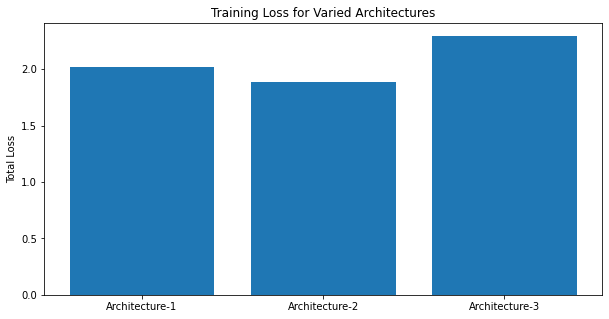

In [57]:
plt.figure(figsize=(10,5))
plt.bar(["Architecture-1","Architecture-2","Architecture-3"],[outputs_et11[0][0],outputs_et21[0][0],outputs_et3[0][0]])
plt.ylabel("Total Loss")
plt.title("Training Loss for Varied Architectures")
plt.show()

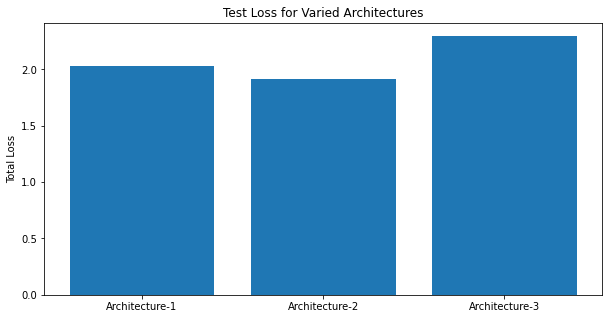

In [58]:
plt.figure(figsize=(10,5))
plt.bar(["Architecture-1","Architecture-2","Architecture-3"],[outputs_ef11[0][0],outputs_ef21[0][0],outputs_ef3[0][0]])
plt.ylabel("Total Loss")
plt.title("Test Loss for Varied Architectures")
plt.show()

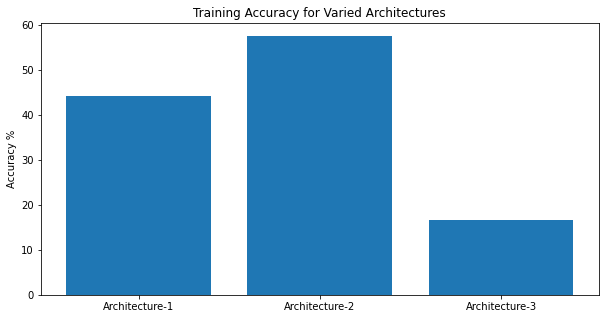

In [59]:
plt.figure(figsize=(10,5))
plt.bar(["Architecture-1","Architecture-2","Architecture-3"],[outputs_et11[0][1],outputs_et21[0][1],outputs_et3[0][1]])
plt.ylabel("Accuracy %")
plt.title("Training Accuracy for Varied Architectures")
plt.show()

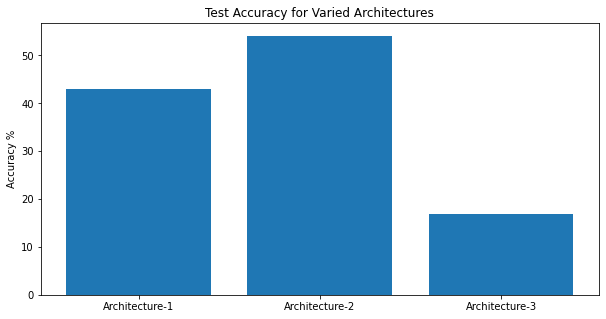

In [60]:
plt.figure(figsize=(10,5))
plt.bar(["Architecture-1","Architecture-2","Architecture-3"],[outputs_ef11[0][1],outputs_ef21[0][1],outputs_ef3[0][1]])
plt.ylabel("Accuracy %")
plt.title("Test Accuracy for Varied Architectures")
plt.show()

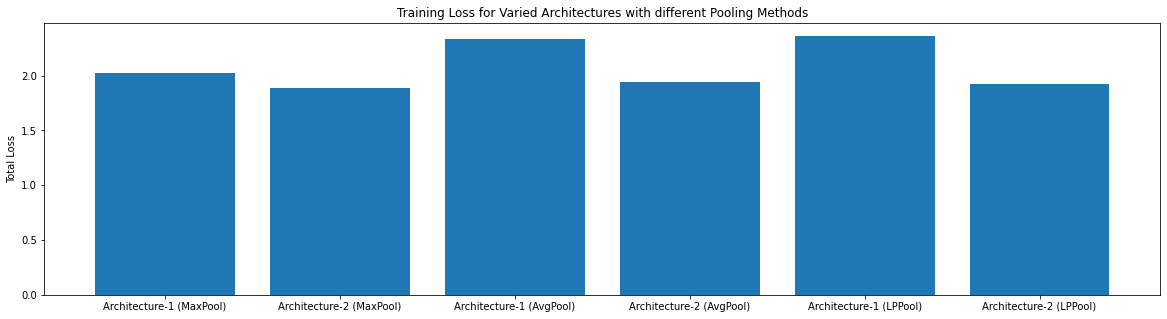

In [61]:
plt.figure(figsize=(20,5))
plt.bar(["Architecture-1 (MaxPool)","Architecture-2 (MaxPool)","Architecture-1 (AvgPool)","Architecture-2 (AvgPool)","Architecture-1 (LPPool)","Architecture-2 (LPPool)"],[outputs_et11[0][0],outputs_et21[0][0],outputs_et12[0][0],outputs_et22[0][0],outputs_et13[0][0],outputs_et23[0][0]])
plt.ylabel("Total Loss")
plt.title("Training Loss for Varied Architectures with different Pooling Methods")
plt.show()

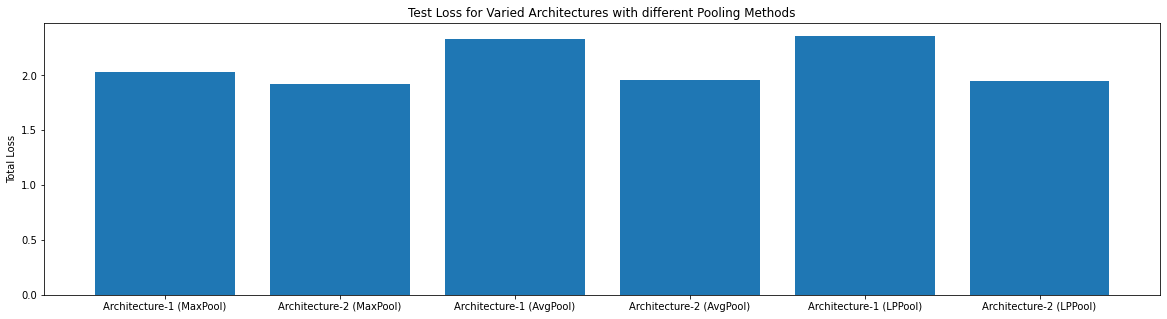

In [62]:
plt.figure(figsize=(20,5))
plt.bar(["Architecture-1 (MaxPool)","Architecture-2 (MaxPool)","Architecture-1 (AvgPool)","Architecture-2 (AvgPool)","Architecture-1 (LPPool)","Architecture-2 (LPPool)"],[outputs_ef11[0][0],outputs_ef21[0][0],outputs_ef12[0][0],outputs_ef22[0][0],outputs_ef13[0][0],outputs_ef23[0][0]])
plt.ylabel("Total Loss")
plt.title("Test Loss for Varied Architectures with different Pooling Methods")
plt.show()

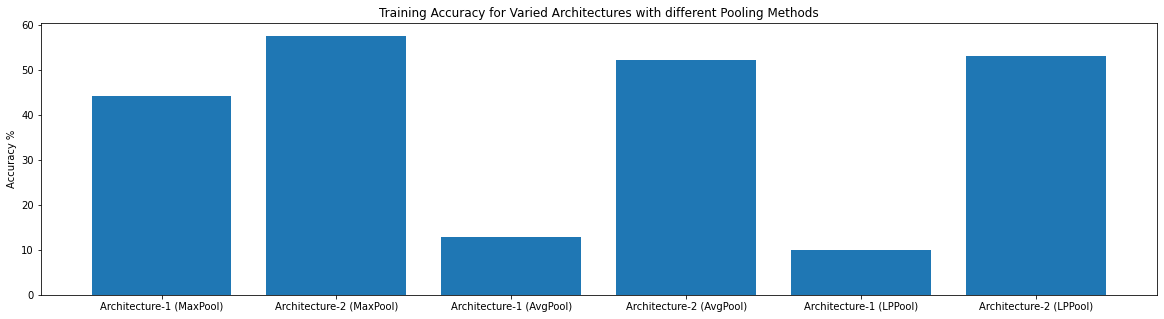

In [63]:
plt.figure(figsize=(20,5))
plt.bar(["Architecture-1 (MaxPool)","Architecture-2 (MaxPool)","Architecture-1 (AvgPool)","Architecture-2 (AvgPool)","Architecture-1 (LPPool)","Architecture-2 (LPPool)"],[outputs_et11[0][1],outputs_et21[0][1],outputs_et12[0][1],outputs_et22[0][1],outputs_et13[0][1],outputs_et23[0][1]])
plt.ylabel("Accuracy %")
plt.title("Training Accuracy for Varied Architectures with different Pooling Methods")
plt.show()

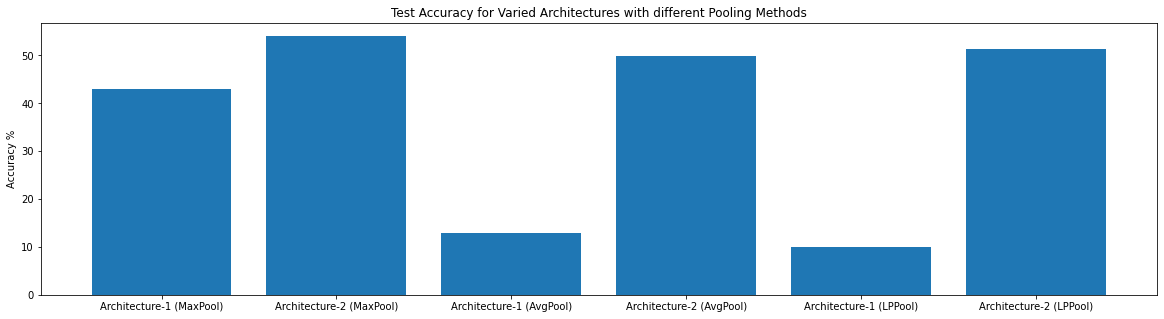

In [64]:
plt.figure(figsize=(20,5))
plt.bar(["Architecture-1 (MaxPool)","Architecture-2 (MaxPool)","Architecture-1 (AvgPool)","Architecture-2 (AvgPool)","Architecture-1 (LPPool)","Architecture-2 (LPPool)"],[outputs_ef11[0][1],outputs_ef21[0][1],outputs_ef12[0][1],outputs_ef22[0][1],outputs_ef13[0][1],outputs_ef23[0][1]])
plt.ylabel("Accuracy %")
plt.title("Test Accuracy for Varied Architectures with different Pooling Methods")
plt.show()

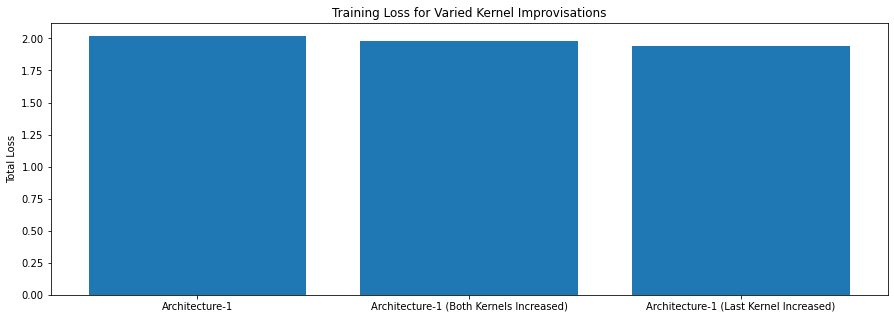

In [65]:
plt.figure(figsize=(15,5))
plt.bar(["Architecture-1","Architecture-1 (Both Kernels Increased)","Architecture-1 (Last Kernel Increased)"],[outputs_et11[0][0],outputs_et112[0][0],outputs_et113[0][0]])
plt.ylabel("Total Loss")
plt.title("Training Loss for Varied Kernel Improvisations")
plt.show()

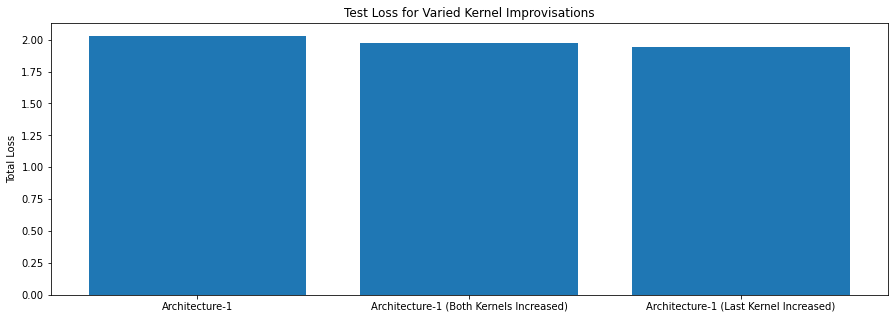

In [66]:
plt.figure(figsize=(15,5))
plt.bar(["Architecture-1","Architecture-1 (Both Kernels Increased)","Architecture-1 (Last Kernel Increased)"],[outputs_ef11[0][0],outputs_ef112[0][0],outputs_ef113[0][0]])
plt.ylabel("Total Loss")
plt.title("Test Loss for Varied Kernel Improvisations")
plt.show()

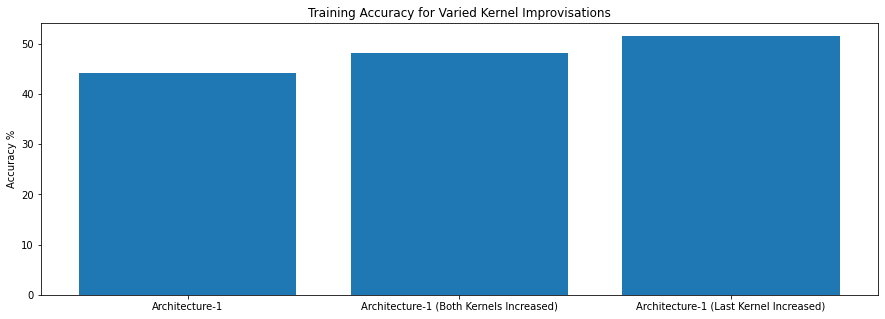

In [67]:
plt.figure(figsize=(15,5))
plt.bar(["Architecture-1","Architecture-1 (Both Kernels Increased)","Architecture-1 (Last Kernel Increased)"],[outputs_et11[0][1],outputs_et112[0][1],outputs_et113[0][1]])
plt.ylabel("Accuracy %")
plt.title("Training Accuracy for Varied Kernel Improvisations")
plt.show()

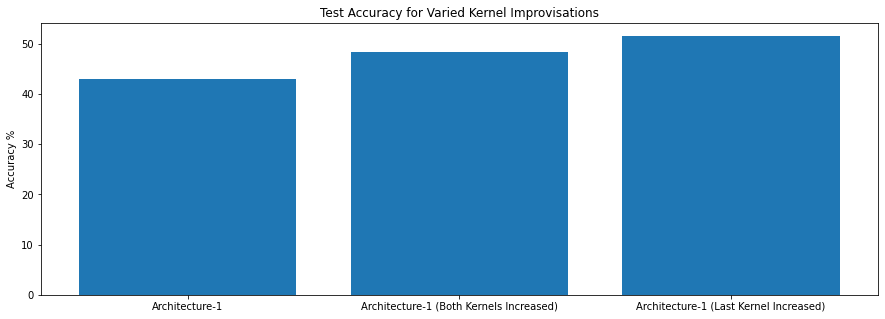

In [68]:
plt.figure(figsize=(15,5))
plt.bar(["Architecture-1","Architecture-1 (Both Kernels Increased)","Architecture-1 (Last Kernel Increased)"],[outputs_ef11[0][1],outputs_ef112[0][1],outputs_ef113[0][1]])
plt.ylabel("Accuracy %")
plt.title("Test Accuracy for Varied Kernel Improvisations")
plt.show()

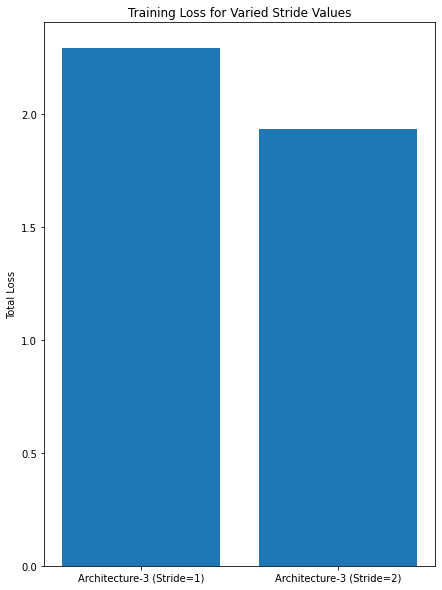

In [69]:
plt.figure(figsize=(7,10))
plt.bar(["Architecture-3 (Stride=1)","Architecture-3 (Stride=2)"],[outputs_et3[0][0],outputs_et31[0][0]])
plt.ylabel("Total Loss")
plt.title("Training Loss for Varied Stride Values")
plt.show()

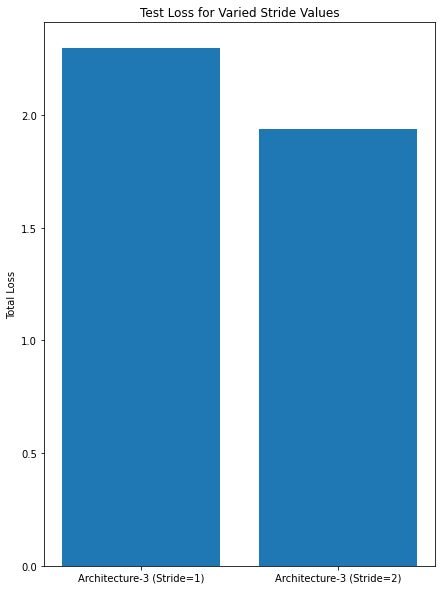

In [70]:
plt.figure(figsize=(7,10))
plt.bar(["Architecture-3 (Stride=1)","Architecture-3 (Stride=2)"],[outputs_ef3[0][0],outputs_ef31[0][0]])
plt.ylabel("Total Loss")
plt.title("Test Loss for Varied Stride Values")
plt.show()

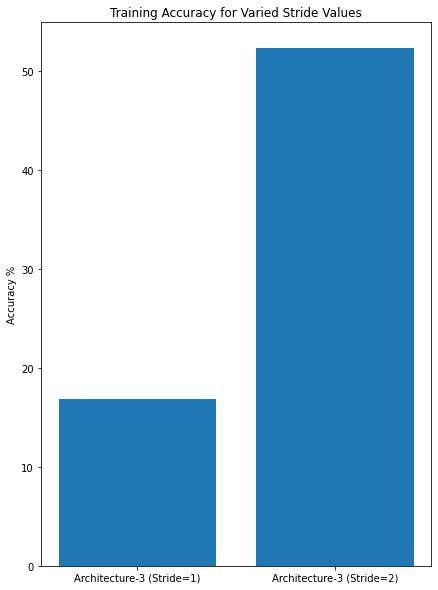

In [71]:
plt.figure(figsize=(7,10))
plt.bar(["Architecture-3 (Stride=1)","Architecture-3 (Stride=2)"],[outputs_ef3[0][1],outputs_ef31[0][1]])
plt.ylabel("Accuracy %")
plt.title("Training Accuracy for Varied Stride Values")
plt.show()

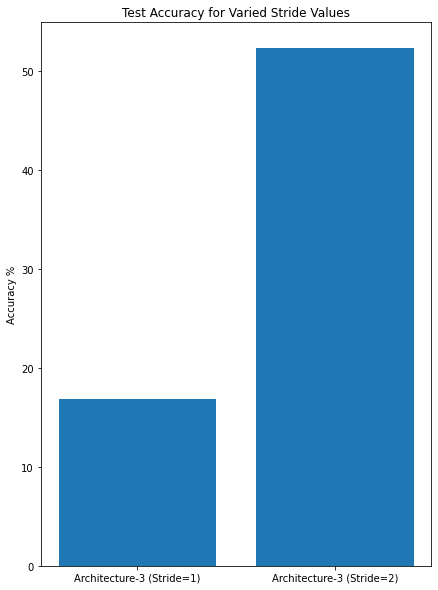

In [72]:
plt.figure(figsize=(7,10))
plt.bar(["Architecture-3 (Stride=1)","Architecture-3 (Stride=2)"],[outputs_ef3[0][1],outputs_ef31[0][1]])
plt.ylabel("Accuracy %")
plt.title("Test Accuracy for Varied Stride Values")
plt.show()